## Incremental Kernel Inverse Update in Gaussian Process Regression

To efficiently update the inverse of the kernel matrix when new data points are added, we use a blockwise inverse formula derived from the **Sherman–Morrison–Woodbury identity**.

Suppose the current inverse of the kernel matrix is known:
$$
K_{NN}^{-1} \in \mathbb{R}^{N \times N}
$$
and we want to augment it with $M$ new data points, leading to an extended kernel matrix:
$$
K_{N+M,N+M} =
\begin{bmatrix}
K_{NN} & B \\
C & D
\end{bmatrix}
$$
where:
- $B \in \mathbb{R}^{N \times M}$ is the cross-covariance between old and new points,
- $C = B^\top \in \mathbb{R}^{M \times N}$,
- $D \in \mathbb{R}^{M \times M}$ is the covariance of the new points.

Then, the inverse of the augmented matrix is given by:
$$
K_{N+M,N+M}^{-1} =
\begin{bmatrix}
K_{NN}^{-1} + K_{NN}^{-1} B S^{-1} C K_{NN}^{-1} & -K_{NN}^{-1} B S^{-1} \\
- S^{-1} C K_{NN}^{-1} & S^{-1}
\end{bmatrix}
$$
where:
$$
S = D - C K_{NN}^{-1} B
$$
is the Schur complement of $K_{NN}$ in the augmented matrix.

### Notation correspondence in code:
- `self.k_xx_inv`: corresponds to $K_{NN}^{-1}$
- `B`: corresponds to $B$
- `C = B^\top`: corresponds to $C$
- `D`: corresponds to $D$
- `temp = S^{-1}`

This incremental scheme allows efficient GP updates **without recomputing the full inverse**, with complexity $\mathcal{O}(NM^2 + M^3)$ instead of $\mathcal{O}(N+M)^3$.


In [1]:
import sys
sys.path.append(f"../../src/utils")

from preprocessing import preprocessing

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import GPy

from onlineGP import *
from modelF import coarse_model
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm
import pickle

from scipy.stats import gaussian_kde
import arviz as az


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')

from utils import * 


 /Users/filippozacchei/anaconda3/envs/progIEVA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2025-04-16 17:37:06,734	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Import

In [2]:
# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 10000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2


In [3]:
print(noise)

0.4999999999999999


In [4]:
# Carica tutti i modelli usando load_model
nsamples = 200
A = np.load(f"data/gp_svd_decomposition_{nsamples}.npz", allow_pickle=True)
Z_r = A['Z_r']  # (640, r)
X_mean = A['X_mean']  # (640, d)
X_std = A['X_std']  # (640, d)
Y_std = A['Y_std']  # (640, d)
Y_min = A['Y_min']

GP_models = []
for t in range(5):  # Per tutti i time steps
    # Open the file in binary read mode ('rb')
    with open(f"./SVD_GP_models/GP_models_matern_{t}_{nsamples}.pkl", 'rb') as f:
        # Load the model using pickle.load() with encoding
        model = pickle.load(f, fix_imports=True, encoding='latin1')
    GP_models.append(model)

In [5]:
num_dimensions = 3  # Number of parameters
nsamples_inverse = 100
seed = 431
sampler = LatinHypercube(d=3, seed=seed)
lhs_samples = sampler.random(n=nsamples_inverse)

# Scale the samples to the desired ranges for each parameter
param_ranges = [(0.1, 0.5), (-0.5, 0.5), (29, 31)]  # Define ranges for each parameter
random_parameters = lhs_samples.copy()
for i, (low, high) in enumerate(param_ranges):
    random_parameters[:, i] = low + (high - low) * lhs_samples[:, i]

In [6]:
X = random_parameters
Y = np.array([coarse_model(X[i,:]) for i in range(nsamples_inverse)])
sample = 10

In [7]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):  
        if (self.pdf(x)!=0): 
            return np.log(self.pdf(x)) 
        else:
            return -np.inf
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [8]:
# Select a true sample for testing
x_true, y_true = X[sample], Y[sample]
print(x_true)
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) # ADDED

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
# = uniform(loc=np.array([0.1, -0.5, 29.0]), scale=np.array([0.5, 0.5, 31.0]) - np.array([0.1, -0.5, 29.0])) #ADDED
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(Y[0,:]))
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 

[ 0.34433361  0.15412003 29.04447481]


In [9]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

forward_model = coarse_model

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=forward_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")


Real Params:  [ 0.34433361  0.15412003 29.04447481]
Optimized Params 1: [ 0.34757622  0.1555799  29.        ]
Optimized Params 2: [ 0.34757622  0.1555799  29.        ]
Optimized Params 3: [ 0.34757622  0.1555799  29.        ]
Optimized Params 4: [ 0.34757622  0.1555799  29.        ]
Optimized Params 5: [ 0.34757622  0.1555799  29.        ]


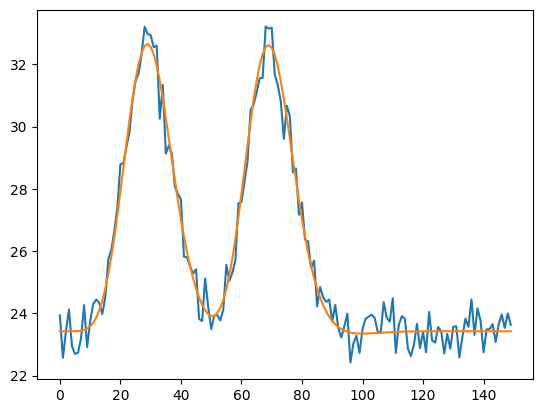

In [10]:
plt.plot(y_observed)
plt.plot(y_true)

## Delayed Acceptace



In [20]:
def gp_predict_z_mean_std(u_centered):
    """
    Predict all latent GP modes (z_pred) and stds (z_std) for a single input.
    """
    z_pred = np.empty(len(GP_models))
    z_std = np.empty(len(GP_models))
    u_input = u_centered.reshape(1, -1)
    
    for i, model in enumerate(GP_models):
        mu, sigma = model.predict(u_input)
        z_pred[i] = mu[0]
        z_std[i] = sigma[0]
    
    return z_pred, z_std

def gp_forward_model(u):
    u_centered = (u - X_mean) / X_std
    z_pred, _ = gp_predict_z_mean_std(u_centered)
    y_mean = (Z_r @ z_pred) * Y_std + Y_min
    return y_mean

def gp_covariance(u):
    u_centered = (u - X_mean) / X_std
    _, z_std = gp_predict_z_mean_std(u_centered)
    cov_gp = Z_r @ np.diag(z_std**2) @ Z_r.T
    cov_y = np.diag(np.diag(cov_gp)) * (Y_std ** 2)
    return cov_y
from scipy.stats import multivariate_normal

class GP_LogLikelihood:
    def __init__(self, y_obs, total_cov):
        self.y_obs = y_obs
        self.total_cov = total_cov

    def loglike(self, model_output):
        return multivariate_normal.logpdf(self.y_obs, mean=model_output, cov=self.total_cov)
    
y_distr_coarse = GP_LogLikelihood(y_observed, cov_likelihood)
y_distr_fine   = tda.GaussianLogLike(y_observed, cov_likelihood)

my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, gp_forward_model)
my_posterior_fine   = tda.Posterior(x_distribution, y_distr_fine, forward_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_gp_prediction_with_uncertainty(x_input, y_true_signal, title="GP prediction"):
    """
    Plot the GP-predicted signal at input x_input with uncertainty bounds.
    
    Parameters:
        x_input: parameter vector (unnormalized)
        y_true_signal: ground truth signal (used for comparison)
        title: optional plot title
    """

    # Center the input for GP
    x_centered = (x_input - X_mean) / X_std

    # GP predictions in latent space
    z_pred = []
    z_std = []

    for model in GP_models:
        mu, sigma = model.predict(x_centered.reshape(1, -1))
        z_pred.append(mu[0])
        z_std.append(sigma[0])

    z_pred = np.array(z_pred)
    z_std = np.array(z_std)

    # Reconstruct signal from latent prediction
    y_pred = (Z_r @ z_pred) * Y_std + Y_min  # (150,)
    
    # Compute predictive covariance in signal space
    cov_gp = Z_r @ np.diag(z_std**2) @ Z_r.T
    std_pred = np.sqrt(np.diag(cov_gp)) * Y_std  # (150,)

    # 95% confidence intervals
    z_score = norm.ppf(0.975)
    y_lower = y_pred - z_score * std_pred
    y_upper = y_pred + z_score * std_pred

    # Plot
    time = np.arange(len(y_pred))
    plt.figure(figsize=(8, 4))
    plt.plot(time, y_pred, label="GP Prediction", color="blue", linewidth=2)
    plt.fill_between(time, y_lower, y_upper, color="blue", alpha=0.2, label="95% Confidence Interval")
    plt.plot(time, y_true_signal, label="True Signal", color="red", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Output Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call this just after the DA loop


🎯 Sample 0, True parameters: [ 0.2117686  -0.46838568 30.42886984]
🔁 Iteration 0, max GP std = inf
Sampling chain 1/1


Running chain, α_c = 0.842, α_f = 0.80: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


📌 Last sample: [ 0.20306262 -0.46875813 29.63948516]
[ 1.01636491 -0.08395252 -0.02065051 -0.00146576 -0.00681951]


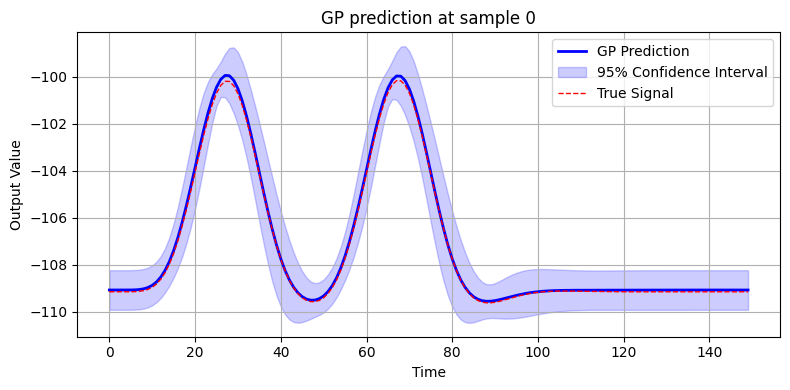

🔁 Iteration 1, max GP std = 1.10e+00
Sampling chain 1/1


Running chain, α_c = 0.684, α_f = 0.70: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


📌 Last sample: [ 0.20358857 -0.4693345  29.63630826]
[ 1.01658762 -0.08369967 -0.02069972 -0.00144583 -0.00680744]


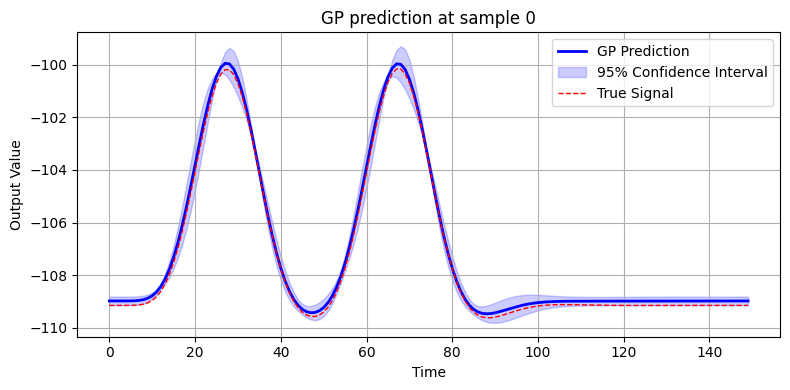

🔁 Iteration 2, max GP std = 5.20e-01
Sampling chain 1/1


Running chain, α_c = 0.895, α_f = 0.90: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


📌 Last sample: [ 0.203227   -0.46527132 29.93708844]
[ 1.01467909 -0.08500692 -0.02099496 -0.00149133 -0.00689675]


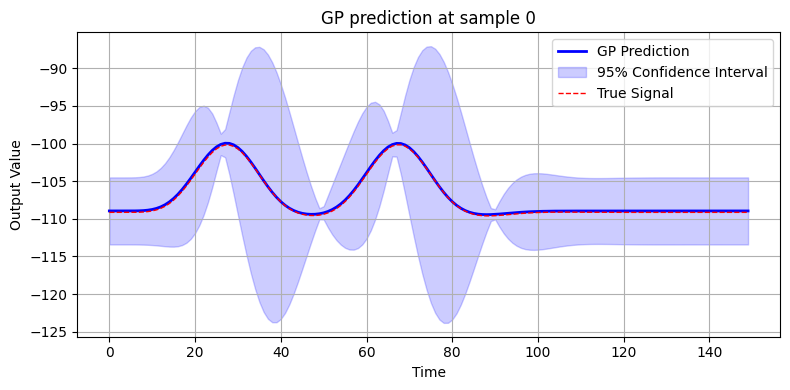

🔁 Iteration 3, max GP std = 9.06e+00
Sampling chain 1/1


Running chain, α_c = 0.947, α_f = 0.90: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


📌 Last sample: [ 0.20365061 -0.4663755  29.87934635]
[ 1.01550686 -0.08458212 -0.02097026 -0.00146875 -0.00687132]


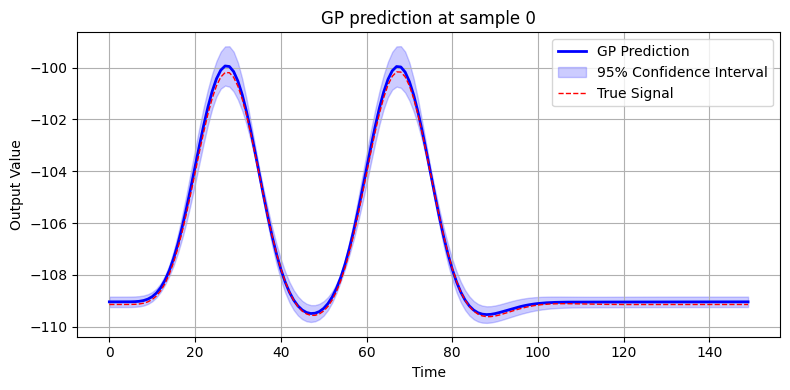

🔁 Iteration 4, max GP std = 4.38e-01
Sampling chain 1/1


Running chain, α_c = 0.684, α_f = 0.70: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


📌 Last sample: [ 0.19821909 -0.47050462 29.09186303]
[ 1.01909328 -0.08404067 -0.01954597 -0.00159391 -0.00677327]


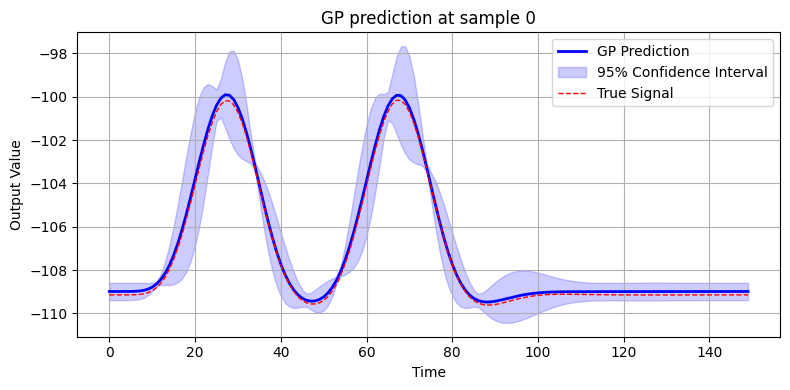

🔁 Iteration 5, max GP std = 1.48e+00
Sampling chain 1/1


Running chain, α_c = 0.632, α_f = 0.60: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


📌 Last sample: [ 0.20092618 -0.46874534 29.45704848]
[ 1.01758915 -0.08420947 -0.02022369 -0.00152628 -0.00681411]


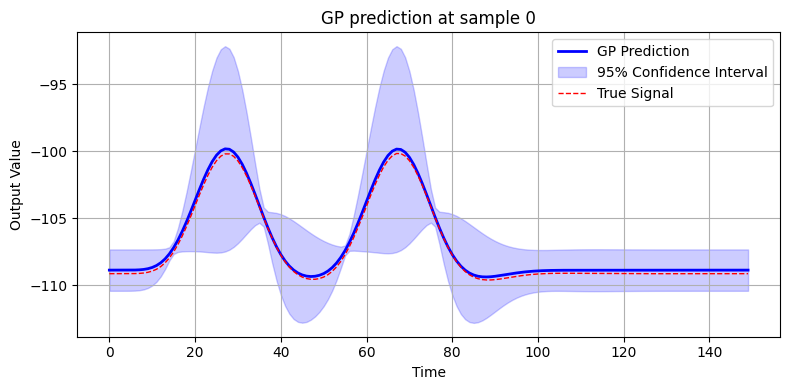

🔁 Iteration 6, max GP std = 4.04e+00
Sampling chain 1/1


Running chain, α_c = 0.895, α_f = 0.90: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


📌 Last sample: [ 0.21086054 -0.46503357 30.58810043]
[ 1.01477806 -0.08390394 -0.02246634 -0.00129216 -0.00691117]


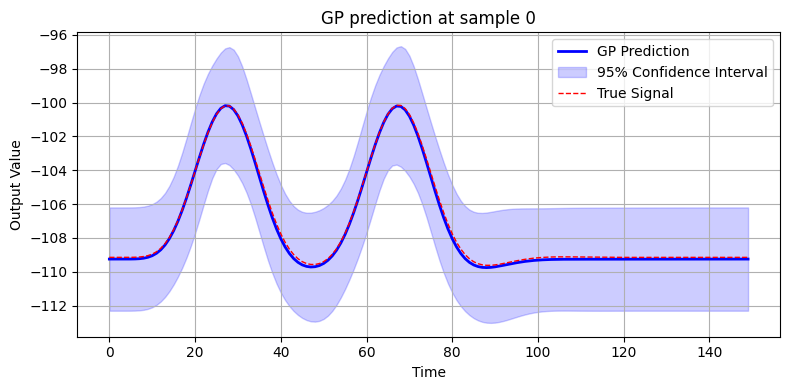

🔁 Iteration 7, max GP std = 1.89e+00
Sampling chain 1/1


Running chain, α_c = 0.789, α_f = 0.80:  90%|█████████ | 9/10 [00:04<00:00,  2.04it/s]

In [ ]:
samples_box = []

for s in range(10):
    # --- 1. Select true sample and simulate observation ---
    x_true, y_true = X[s], Y[s]
    print(f"\n🎯 Sample {s}, True parameters: {x_true}")
    
    y_observed = y_true + np.random.normal(scale=noise, size=y_true.shape[0])
    
    # Observation covariance
    y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood)

    # --- 2. Least-squares optimization to initialize proposal ---
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed,
        forward_model=coarse_model,
        start_point=np.array([0.2, 0.25, 30.0]),
        bounds=MCMC_SETTINGS['bounds']
    )
    
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling=0.1, adaptive=True)

    # --- 4. Delayed Acceptance Loop ---
    max_gp_std = np.inf
    iteration = 0
    last_sample = init_guess

    while max_gp_std > 1e-6:
        
        cov_gp = gp_covariance(init_guess)
        total_cov = cov_likelihood + cov_gp
        y_distr_coarse = GP_LogLikelihood(y_observed, total_cov)

        # Build posteriors
        my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, gp_forward_model)
        my_posterior_fine   = tda.Posterior(x_distribution, y_distr_fine, forward_model)
        my_posteriors = [my_posterior_coarse, my_posterior_fine]
        print(f"🔁 Iteration {iteration}, max GP std = {max_gp_std:.2e}")

        # Sample via DA
        samples = tda.sample(
            my_posteriors,
            my_proposal,
            iterations=10,
            n_chains=1,
            initial_parameters=last_sample,
            subsampling_rate=1
        )

        # Convert to inference data
        idata = tda.to_inference_data(samples, level='fine', parameter_names=['Overetch', 'Offset', 'Thickness'])
        idata = idata.sel(draw=slice(10,None,1))  # Burn-in removal

        # Extract last sample
        last_sample = np.array([
            idata.posterior["Overetch"].values[0, -1],
            idata.posterior["Offset"].values[0, -1],
            idata.posterior["Thickness"].values[0, -1]
        ])
        print(f"📌 Last sample: {last_sample}")

        # --- 5. Online GP refinement ---
        new_data_centered = (last_sample - X_mean) / X_std
        y_data = coarse_model(last_sample)
        y_data_centered = ((y_data - Y_min) / Y_std) @ Z_r
        print(y_data_centered)
        for i in range(len(GP_models)):
            GP_models[i].fit(new_data_centered.reshape(1, -1), y_data_centered[i].reshape(-1,1), optimize_scales=False)

        plot_gp_prediction_with_uncertainty(x_input=init_guess, y_true_signal=y_true, title=f"GP prediction at sample {s}")
        
        
        # Update condition
        max_gp_std = np.max(np.sqrt(np.diag(gp_covariance(last_sample))))
        init_guess = last_sample  # Next starting point
        iteration += 1

    # Final inference (using GP only)
    print("✅ GP confidence sufficient. Switching to GP-only inference.")
    samples_gp_only = tda.sample(
        [my_posterior_coarse],
        my_proposal,
        iterations=1000,
        n_chains=1,
        initial_parameters=init_guess,
        subsampling_rate=1
    )
    idata_gp = tda.to_inference_data(samples_gp_only, level='coarse', parameter_names=['Overetch', 'Offset', 'Thickness'])
    samples_box.append(idata_gp)

In [ ]:
new_data_centered

array([-0.89592003, -1.64974392, -0.97209852])